In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery as bq

%matplotlib inline

In [2]:
probe = pd.read_table("./metadata/sig-DMD.union.includeERR.hm450probes", sep="\t", header=None)
probe.columns = ['chrom', 'start', 'end', 'probe_id', 
                 'UCSC.RefGene_Group', 'UCSC.RefGene_Accession', 'UCSC.RefGene_Name', 
                 'sig-DMD', 'DMV', 'pairs', 'no_pairs']

print(probe.shape)
probe.head()

(25329, 11)


chrom   start     end    probe_id UCSC.RefGene_Group UCSC.RefGene_Accession  \
0  chr1  864878  864880  cg02896266               Body              NM_152486   
1  chr1  931326  931328  cg03648020                NaN                    NaN   
2  chr1  933305  933307  cg01729262                NaN                    NaN   
3  chr1  933387  933389  cg15882305                NaN                    NaN   
4  chr1  933684  933686  cg15713103                NaN                    NaN   

  UCSC.RefGene_Name    sig-DMD    DMV  \
0            SAMD11  sig-DMD_1  DMV_4   
1               NaN  sig-DMD_2  DMV_6   
2               NaN  sig-DMD_2  DMV_6   
3               NaN  sig-DMD_2  DMV_6   
4               NaN  sig-DMD_2  DMV_6   

                                     pairs  no_pairs  
0                 nontrip_trip,normal_trip         2  
1  nontrip_trip,normal_nontrip,normal_trip         3  
2  nontrip_trip,normal_nontrip,normal_trip         3  
3  nontrip_trip,normal_nontrip,normal_trip         3  
4  nontrip_trip,normal_nontrip,normal_trip         3

In [4]:
sample = pd.read_table("./metadata/subtype_metadata.tsv", sep="\t")

print(sample.shape)
sample.head()

(1535, 5)


case_barcode    sample_barcode  sample_type     sample_type_name subtype
0  TCGA-A2-A04P  TCGA-A2-A04P-01A            1  Primary solid Tumor   Basal
1  TCGA-AR-A0TP  TCGA-AR-A0TP-01A            1  Primary solid Tumor   Basal
2  TCGA-GM-A2DF  TCGA-GM-A2DF-01A            1  Primary solid Tumor   Basal
3  TCGA-BH-A0C0  TCGA-BH-A0C0-01A            1  Primary solid Tumor    LumB
4  TCGA-BH-A0C0  TCGA-BH-A0C0-01A            1  Primary solid Tumor  Normal

In [5]:
sample_barcodes = ", ".join("'%s'" % w for w in sample.sample_barcode)
probe_ids = ", ".join("'%s'" % w for w in probe.probe_id)

In [6]:
client = bq.Client()
methylation = 'isb-cgc.TCGA_hg19_data_v0.DNA_Methylation'

query="""\
SELECT 
    case_barcode, sample_barcode, aliquot_barcode, probe_id, beta_value
FROM
    `{}`
WHERE
    platform = "HumanMethylation450" AND
    sample_barcode IN ({}) AND probe_id IN ({})
""".format(methylation, sample_barcodes, probe_ids)

subtype_meth = client.query(query).to_dataframe()

print(subtype_meth.shape)

subtype_meth.head()

(20313452, 5)


case_barcode    sample_barcode               aliquot_barcode    probe_id  \
0  TCGA-C8-A274  TCGA-C8-A274-01A  TCGA-C8-A274-01A-11D-A16G-05  cg15121959   
1  TCGA-D8-A1XW  TCGA-D8-A1XW-01A  TCGA-D8-A1XW-01A-11D-A14N-05  cg11573093   
2  TCGA-E9-A1RF  TCGA-E9-A1RF-11A  TCGA-E9-A1RF-11A-32D-A161-05  cg22949832   
3  TCGA-E2-A576  TCGA-E2-A576-01A  TCGA-E2-A576-01A-11D-A31V-05  cg21780202   
4  TCGA-LD-A74U  TCGA-LD-A74U-01A  TCGA-LD-A74U-01A-13D-A33F-05  cg06316219   

   beta_value  
0        0.98  
1        0.99  
2        0.96  
3        0.95  
4        0.96

In [7]:
subtype_meth_bigtable = pd.merge(subtype_meth, sample, how='inner', on=["sample_barcode", "case_barcode"])

print(subtype_meth_bigtable.shape)
subtype_meth_bigtable.head()

(24585661, 8)


case_barcode    sample_barcode               aliquot_barcode    probe_id  \
0  TCGA-C8-A274  TCGA-C8-A274-01A  TCGA-C8-A274-01A-11D-A16G-05  cg15121959   
1  TCGA-C8-A274  TCGA-C8-A274-01A  TCGA-C8-A274-01A-11D-A16G-05  cg16630303   
2  TCGA-C8-A274  TCGA-C8-A274-01A  TCGA-C8-A274-01A-11D-A16G-05  cg11081894   
3  TCGA-C8-A274  TCGA-C8-A274-01A  TCGA-C8-A274-01A-11D-A16G-05  cg01983105   
4  TCGA-C8-A274  TCGA-C8-A274-01A  TCGA-C8-A274-01A-11D-A16G-05  cg24764310   

   beta_value  sample_type     sample_type_name subtype  
0        0.98            1  Primary solid Tumor    LumB  
1        0.95            1  Primary solid Tumor    LumB  
2        0.95            1  Primary solid Tumor    LumB  
3        0.95            1  Primary solid Tumor    LumB  
4        0.97            1  Primary solid Tumor    LumB

In [8]:
print("Sample types")
print(subtype_meth_bigtable.drop_duplicates(subset="sample_barcode").sample_type_name.value_counts())
print("\n")

print("BRCA subtypes")
print(subtype_meth_bigtable.drop_duplicates(subset="case_barcode").subtype.value_counts())

Sample types
Primary solid Tumor    789
Solid Tissue Normal     98
Metastatic               5
Name: sample_type_name, dtype: int64


BRCA subtypes
LumA      420
LumB      140
Basal     133
Normal     51
Her2       45
Name: subtype, dtype: int64


In [9]:
subtype_meth_bigtable.to_csv("./datasets/subtype_meth_bigtable.HM450.tsv", sep="\t", index=False)

# Include normal

In [ ]:
subtype_meth_bigtable = pd.read_table("./datasets/subtype_meth_bigtable.HM450.tsv", sep="\t")

print(subtype_meth_bigtable.shape)
subtype_meth_table.head()

In [29]:
matrix = subtype_meth_bigtable.pivot(index='probe_id', columns='aliquot_barcode', values='beta_value')

print(matrix.shape)
matrix.head()

(1605, 416)


aliquot_barcode  TCGA-5L-AAT0-01A-12D-A41Q-05  TCGA-5L-AAT1-01A-12D-A41Q-05  \
probe_id                                                                      
cg00000321                               0.59                          0.40   
cg00008036                               0.25                          0.42   
cg00024494                               0.83                          0.59   
cg00035316                               0.56                          0.47   
cg00040588                               0.33                          0.33   

aliquot_barcode  TCGA-5T-A9QA-01A-11D-A41Q-05  TCGA-A1-A0SF-01A-11D-A145-05  \
probe_id                                                                      
cg00000321                               0.78                          0.26   
cg00008036                               0.60                          0.14   
cg00024494                               0.93                          0.70   
cg00035316                               0.87                          0.54   
cg00040588                               0.84                          0.30   

aliquot_barcode  TCGA-A1-A0SQ-01A-21D-A145-05  TCGA-A2-A04R-01A-41D-A10A-05  \
probe_id                                                                      
cg00000321                               0.12                          0.07   
cg00008036                               0.10                          0.62   
cg00024494                               0.90                          0.94   
cg00035316                               0.78                          0.65   
cg00040588                               0.57                          0.74   

aliquot_barcode  TCGA-A2-A0CK-01A-11D-A22B-05  TCGA-A2-A0CO-01A-13D-A22B-05  \
probe_id                                                                      
cg00000321                               0.45                          0.31   
cg00008036                               0.35                          0.28   
cg00024494                               0.76                          0.44   
cg00035316                               0.71                          0.69   
cg00040588                               0.30                          0.57   

aliquot_barcode  TCGA-A2-A0CR-01A-11D-A22B-05  TCGA-A2-A0CT-01A-31D-A10P-05  \
probe_id                                                                      
cg00000321                               0.32                          0.76   
cg00008036                               0.26                          0.35   
cg00024494                               0.54                          0.94   
cg00035316                               0.40                          0.82   
cg00040588                               0.36                          0.53   

aliquot_barcode              ...               TCGA-S3-A6ZG-01A-22D-A32T-05  \
probe_id                     ...                                              
cg00000321                   ...                                       0.65   
cg00008036                   ...                                       0.31   
cg00024494                   ...                                       0.60   
cg00035316                   ...                                       0.64   
cg00040588                   ...                                       0.71   

aliquot_barcode  TCGA-S3-A6ZH-01A-22D-A32T-05  TCGA-S3-AA11-01A-31D-A41Q-05  \
probe_id                                                                      
cg00000321                               0.28                          0.65   
cg00008036                               0.21                          0.52   
cg00024494                               0.90                          0.91   
cg00035316                               0.59                          0.78   
cg00040588                               0.67                          0.50   

aliquot_barcode  TCGA-S3-AA12-01A-11D-A41Q-05  TCGA-S3-AA17-01A-11D-A41Q-05  \
probe_id                                   

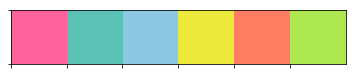

In [30]:
sns.palplot(sns.color_palette(["#ff639c", "#5bc1b5", "#8cc8e2", "#edea3d", "#ff7e63", "#aee851"]))

In [31]:
color_matrix = pd.DataFrame()
df = subtype_meth_bigtable.drop_duplicates(subset="aliquot_barcode")

c = dict(zip(df['sample_type_name'].unique(), ["#ff639c", "#5bc1b5"]))
color_matrix['Sample types'] = df['sample_type_name'].map(c)

c = dict(zip(df['initial_response'].unique(), ["#ffffff", "#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ffffff", "#ff7e63", "#ffffff", "#aee851"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

Sample types Initial response Recurrence status
aliquot_barcode                                                             
TCGA-E9-A22B-01A-11D-A161-05      #ff639c          #ffffff           #ffffff
TCGA-AC-A2FF-01A-11D-A17F-05      #ff639c          #8cc8e2           #ffffff
TCGA-A2-A1FW-01A-11D-A13K-05      #ff639c          #ffffff           #ffffff
TCGA-A2-A0CT-01A-31D-A10P-05      #ff639c          #ffffff           #ffffff
TCGA-S3-AA11-01A-31D-A41Q-05      #ff639c          #8cc8e2           #ffffff

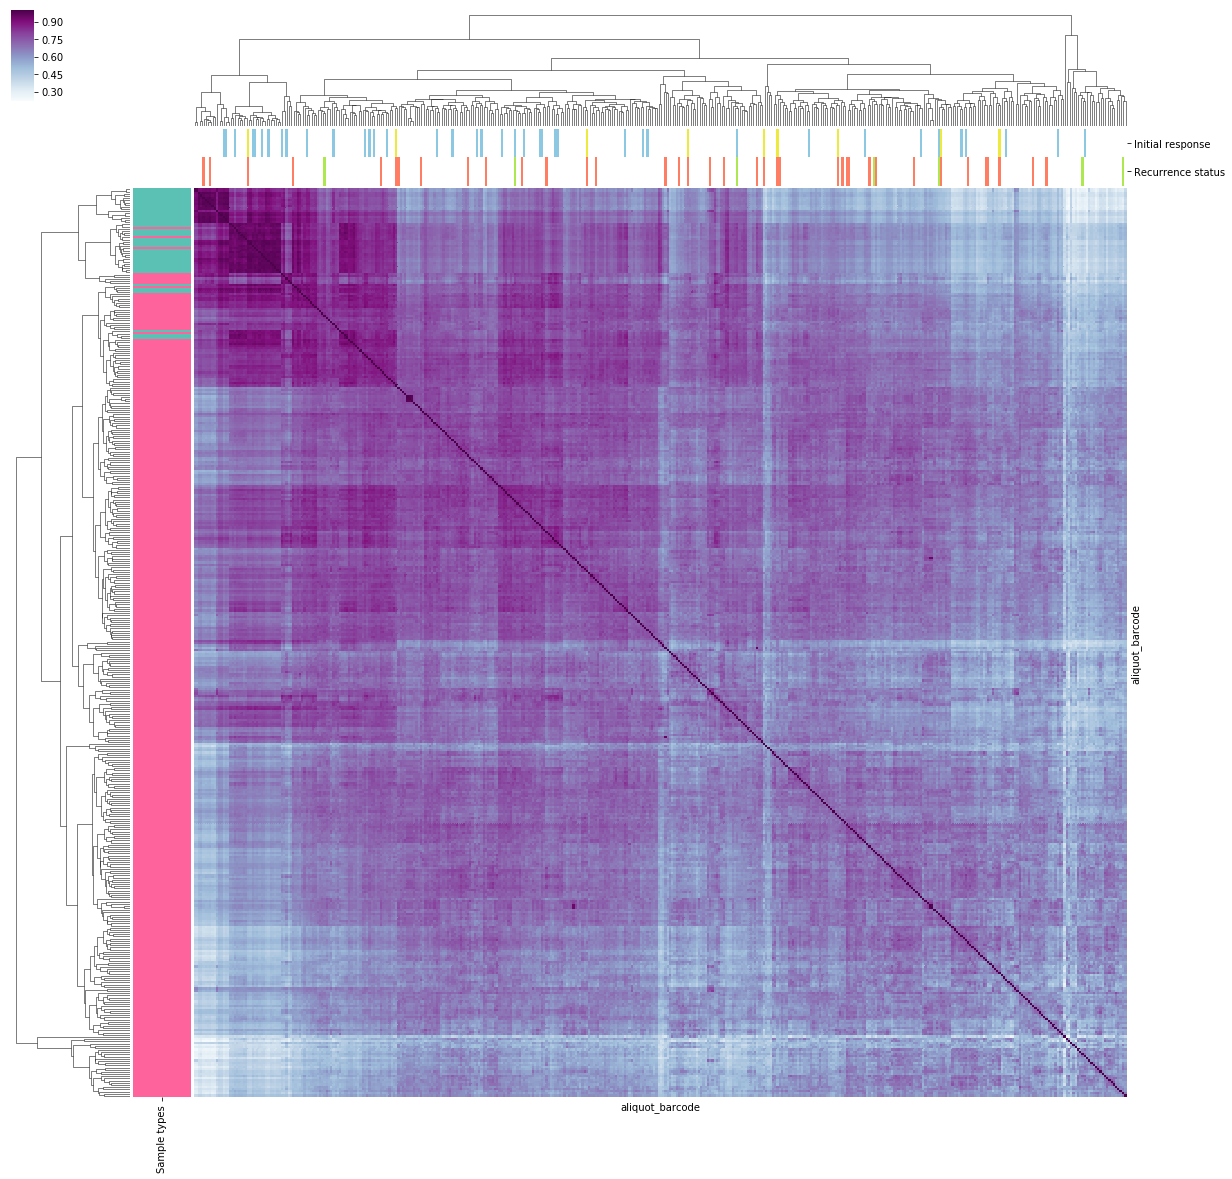

In [34]:
sns.clustermap(data=matrix.corr(), method='average', 
               row_colors=color_matrix['Sample types'], col_colors = color_matrix.iloc[:,1:],
               cmap="BuPu", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)

# Exclude normal

In [35]:
hormone_meth_bigtable['sample_type'].value_counts()

1     599744
11     67348
Name: sample_type, dtype: int64

In [36]:
exclude_normal = hormone_meth_bigtable.loc[hormone_meth_bigtable['sample_type'] == 1]
matrix = exclude_normal.pivot(index='probe_id', columns='aliquot_barcode', values='beta_value')

print(matrix.shape)
matrix.head()

(1605, 374)


aliquot_barcode  TCGA-5L-AAT0-01A-12D-A41Q-05  TCGA-5L-AAT1-01A-12D-A41Q-05  \
probe_id                                                                      
cg00000321                               0.59                          0.40   
cg00008036                               0.25                          0.42   
cg00024494                               0.83                          0.59   
cg00035316                               0.56                          0.47   
cg00040588                               0.33                          0.33   

aliquot_barcode  TCGA-5T-A9QA-01A-11D-A41Q-05  TCGA-A1-A0SF-01A-11D-A145-05  \
probe_id                                                                      
cg00000321                               0.78                          0.26   
cg00008036                               0.60                          0.14   
cg00024494                               0.93                          0.70   
cg00035316                               0.87                          0.54   
cg00040588                               0.84                          0.30   

aliquot_barcode  TCGA-A1-A0SQ-01A-21D-A145-05  TCGA-A2-A04R-01A-41D-A10A-05  \
probe_id                                                                      
cg00000321                               0.12                          0.07   
cg00008036                               0.10                          0.62   
cg00024494                               0.90                          0.94   
cg00035316                               0.78                          0.65   
cg00040588                               0.57                          0.74   

aliquot_barcode  TCGA-A2-A0CK-01A-11D-A22B-05  TCGA-A2-A0CO-01A-13D-A22B-05  \
probe_id                                                                      
cg00000321                               0.45                          0.31   
cg00008036                               0.35                          0.28   
cg00024494                               0.76                          0.44   
cg00035316                               0.71                          0.69   
cg00040588                               0.30                          0.57   

aliquot_barcode  TCGA-A2-A0CR-01A-11D-A22B-05  TCGA-A2-A0CT-01A-31D-A10P-05  \
probe_id                                                                      
cg00000321                               0.32                          0.76   
cg00008036                               0.26                          0.35   
cg00024494                               0.54                          0.94   
cg00035316                               0.40                          0.82   
cg00040588                               0.36                          0.53   

aliquot_barcode              ...               TCGA-S3-A6ZG-01A-22D-A32T-05  \
probe_id                     ...                                              
cg00000321                   ...                                       0.65   
cg00008036                   ...                                       0.31   
cg00024494                   ...                                       0.60   
cg00035316                   ...                                       0.64   
cg00040588                   ...                                       0.71   

aliquot_barcode  TCGA-S3-A6ZH-01A-22D-A32T-05  TCGA-S3-AA11-01A-31D-A41Q-05  \
probe_id                                                                      
cg00000321                               0.28                          0.65   
cg00008036                               0.21                          0.52   
cg00024494                               0.90                          0.91   
cg00035316                               0.59                          0.78   
cg00040588                               0.67                          0.50   

aliquot_barcode  TCGA-S3-AA12-01A-11D-A41Q-05  TCGA-S3-AA17-01A-11D-A41Q-05  \
probe_id                                   

In [37]:
color_matrix = pd.DataFrame()
df = exclude_normal.drop_duplicates(subset="aliquot_barcode")

c = dict(zip(df['initial_response'].unique(), ["#ffffff", "#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ffffff", "#ff7e63", "#ffffff", "#aee851"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

Initial response Recurrence status
aliquot_barcode                                                
TCGA-E9-A22B-01A-11D-A161-05          #ffffff           #ffffff
TCGA-AC-A2FF-01A-11D-A17F-05          #8cc8e2           #ffffff
TCGA-A2-A1FW-01A-11D-A13K-05          #ffffff           #ffffff
TCGA-A2-A0CT-01A-31D-A10P-05          #ffffff           #ffffff
TCGA-S3-AA11-01A-31D-A41Q-05          #8cc8e2           #ffffff

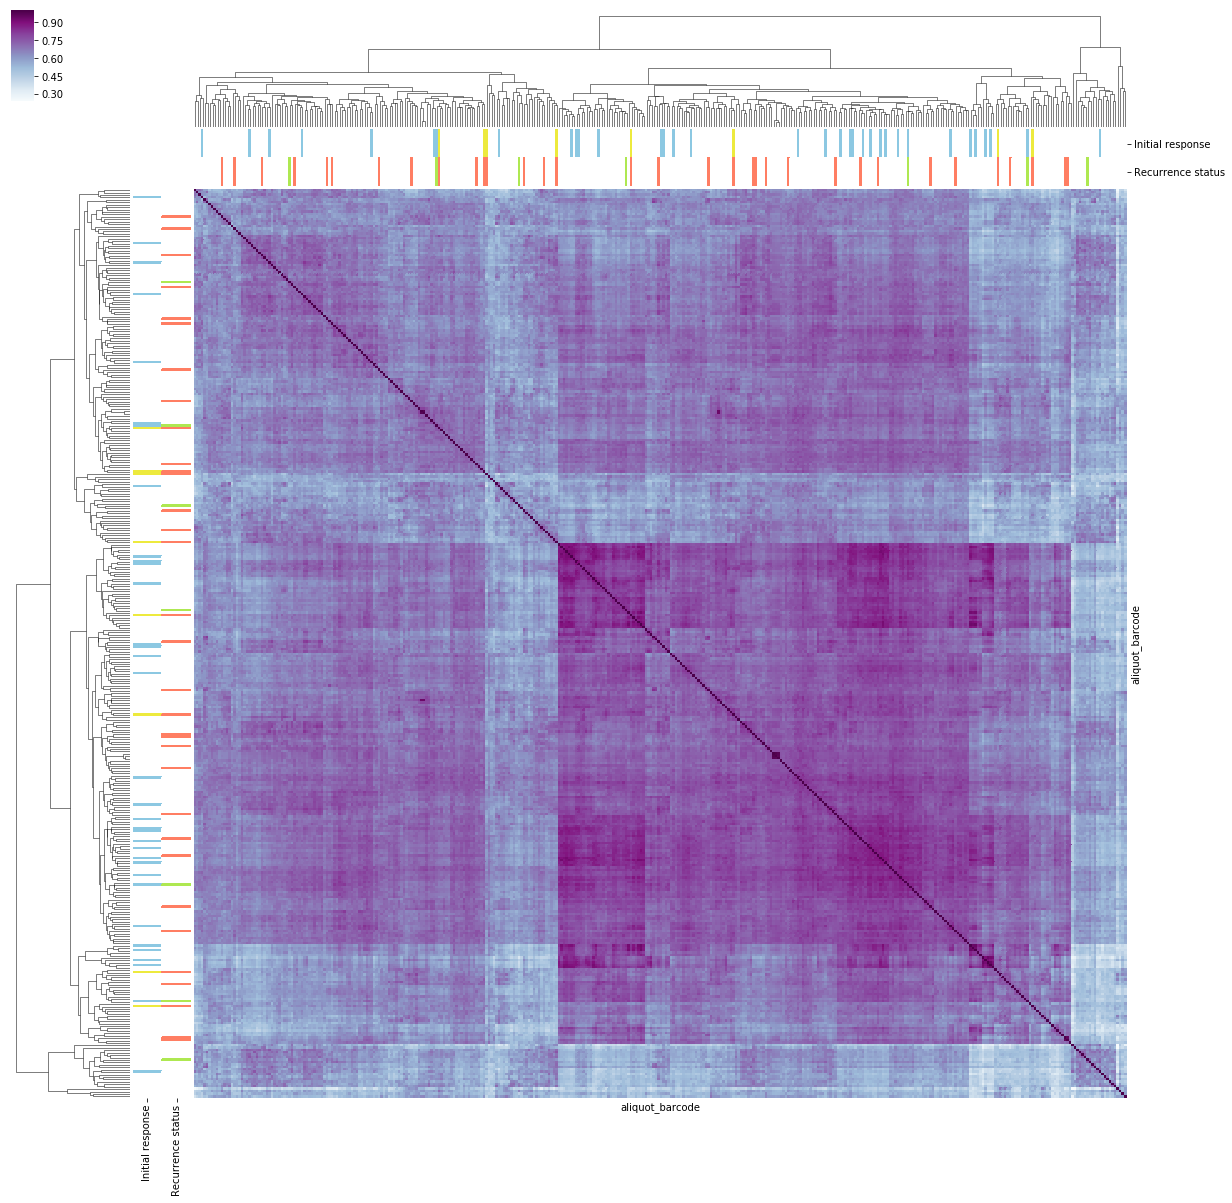

In [38]:
sns.clustermap(data=matrix.corr(), method='weighted', 
               row_colors = color_matrix, col_colors = color_matrix,
               cmap="BuPu", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)

# Normal tissues only

In [39]:
only_normal = hormone_meth_bigtable.loc[hormone_meth_bigtable['sample_type'] == 11]
matrix = only_normal.pivot(index='probe_id', columns='aliquot_barcode', values='beta_value')

print(matrix.shape)
matrix.head()

(1605, 42)


aliquot_barcode  TCGA-A7-A0CH-11A-32D-A10Q-05  TCGA-A7-A0D9-11A-53D-A10Q-05  \
probe_id                                                                      
cg00000321                               0.26                          0.21   
cg00008036                               0.17                          0.07   
cg00024494                               0.72                          0.50   
cg00035316                               0.21                          0.11   
cg00040588                               0.60                          0.43   

aliquot_barcode  TCGA-A7-A0DB-11A-33D-A093-05  TCGA-A7-A0DC-11A-41D-A10Q-05  \
probe_id                                                                      
cg00000321                               0.25                          0.26   
cg00008036                               0.09                          0.10   
cg00024494                               0.59                          0.83   
cg00035316                               0.13                          0.31   
cg00040588                               0.46                          0.53   

aliquot_barcode  TCGA-A7-A13F-11A-42D-A12R-05  TCGA-A7-A13G-11A-51D-A13T-05  \
probe_id                                                                      
cg00000321                               0.26                          0.28   
cg00008036                               0.11                          0.09   
cg00024494                               0.70                          0.61   
cg00035316                               0.21                          0.19   
cg00040588                               0.41                          0.39   

aliquot_barcode  TCGA-AC-A2FB-11A-13D-A17F-05  TCGA-AC-A2FF-11A-13D-A17F-05  \
probe_id                                                                      
cg00000321                               0.27                          0.30   
cg00008036                               0.19                          0.12   
cg00024494                               0.67                          0.75   
cg00035316                               0.33                          0.21   
cg00040588                               0.48                          0.37   

aliquot_barcode  TCGA-AC-A2FG-11A-22D-A17F-05  TCGA-BH-A0AY-11A-23D-A10Q-05  \
probe_id                                                                      
cg00000321                               0.29                          0.23   
cg00008036                               0.15                          0.13   
cg00024494                               0.70                          0.78   
cg00035316                               0.45                          0.23   
cg00040588                               0.39                          0.57   

aliquot_barcode              ...               TCGA-E9-A1NA-11A-33D-A145-05  \
probe_id                     ...                                              
cg00000321                   ...                                       0.29   
cg00008036                   ...                                       0.16   
cg00024494                   ...                                       0.62   
cg00035316                   ...                                       0.26   
cg00040588                   ...                                       0.48   

aliquot_barcode  TCGA-E9-A1NE-11A-43D-A14N-05  TCGA-E9-A1NF-11A-73D-A14H-05  \
probe_id                                                                      
cg00000321                               0.20                          0.23   
cg00008036                               0.08                          0.12   
cg00024494                               0.72                          0.62   
cg00035316                               0.16                          0.20   
cg00040588                               0.43                          0.40   

aliquot_barcode  TCGA-E9-A1NG-11A-52D-A14N-05  TCGA-E9-A1R7-11A-42D-A14N-05  \
probe_id                                   

In [40]:
color_matrix = pd.DataFrame()
df = only_normal.drop_duplicates(subset="aliquot_barcode")

c = dict(zip(df['initial_response'].unique(), ["#ffffff", "#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ffffff", "#ff7e63", "#ffffff", "#aee851"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

Initial response Recurrence status
aliquot_barcode                                                
TCGA-A7-A13G-11A-51D-A13T-05          #ffffff           #ffffff
TCGA-E9-A1NA-11A-33D-A145-05          #ffffff           #ff7e63
TCGA-E9-A1RC-11A-33D-A161-05          #ffffff           #ff7e63
TCGA-E9-A1NF-11A-73D-A14H-05          #ffffff           #ffffff
TCGA-E2-A1IO-11A-21D-A145-05          #ffffff           #ff7e63

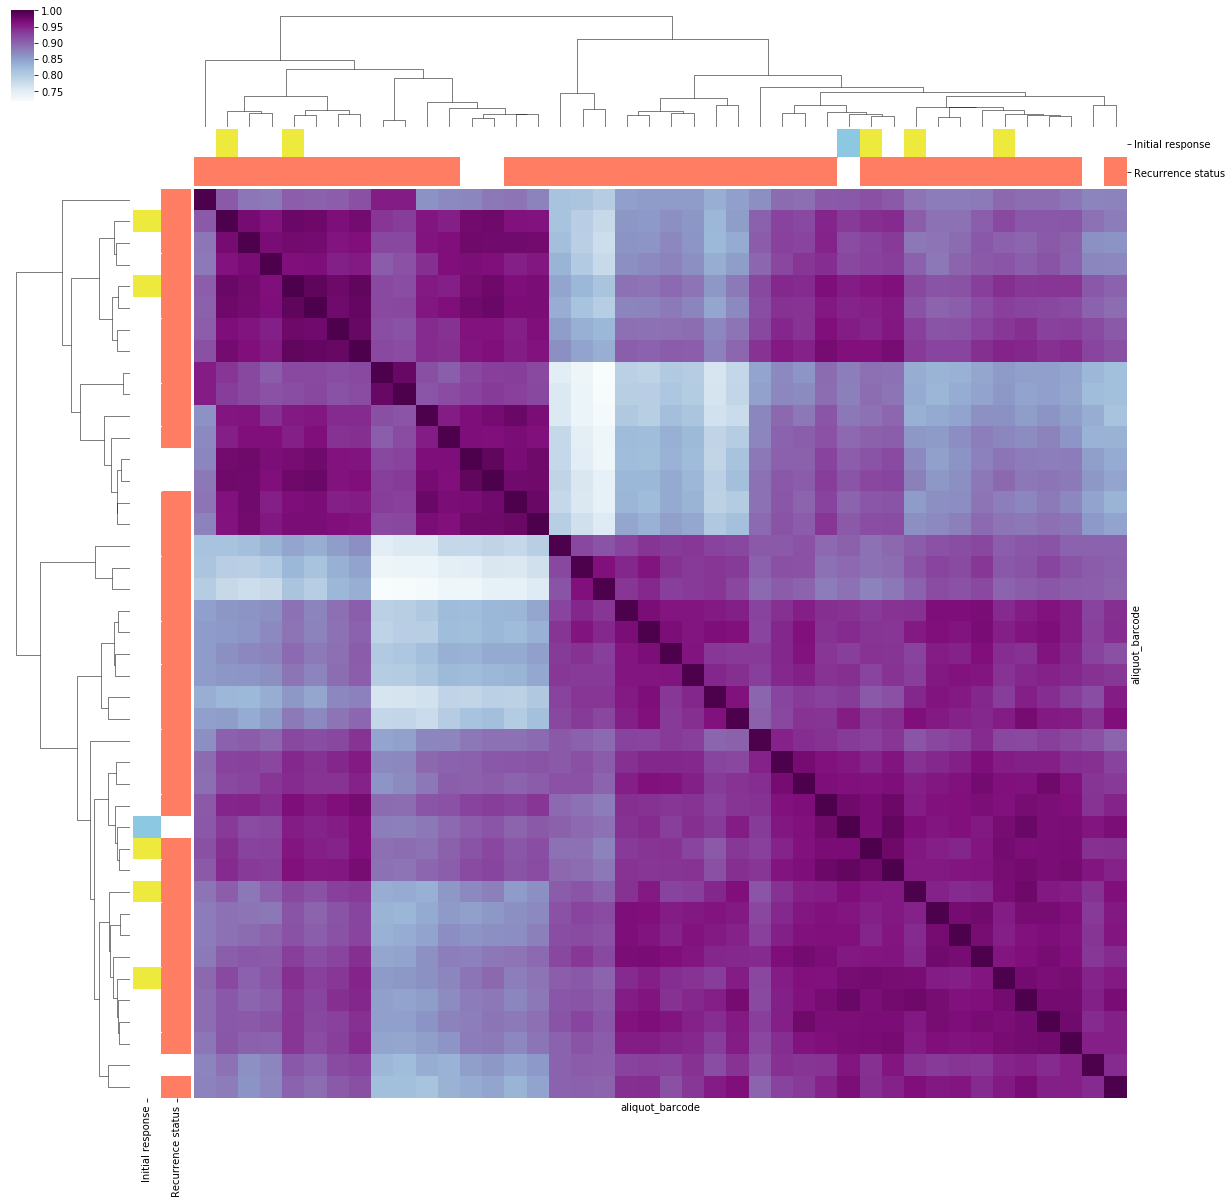

In [41]:
sns.clustermap(data=matrix.corr(), method='average', 
               row_colors = color_matrix, col_colors = color_matrix,
               cmap="BuPu", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)